In [1]:
import math
import numpy as np
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.stats import poisson
from patsy import dmatrices
import statsmodels.graphics.tsaplots as tsa
from matplotlib import pyplot as plt
from statsmodels.tools.numdiff import approx_hess1, approx_hess2, approx_hess3
import scipy.optimize as opt
import pandas as pd

# GP1 HMM

In [2]:
def GP1_pmf(y, mu, alpha):
        if alpha == 1:
                alpha = 0.9
        phi = 1/(1-alpha)

        return ( mu * ( (mu + (phi-1)*y)**(y-1) ) * (phi**(-y)) * (1/math.exp( (mu + (phi -1)*y) / phi )) ) / (math.factorial(int(y)))

def GP1_var(mu, alpha):
        return ( mu ) / (1-alpha)**2

In [3]:
class GP1HMM(GenericLikelihoodModel):
    #endog:Yt; exog: X list of emission; k: #state; covariate:corvariate list of transtion matrix;
    #length: list of mutlti time serial data length, e.g. [15,22,30]; extra_params_names: name of parameters
    def __init__(self, endog, exog, k_regimes=2, covariate = None , length=None,loglike=None, score=None, hessian=None,
                 missing='none', extra_params_names=None, **kwds):
        super(GP1HMM, self).__init__(endog=endog, exog=exog, loglike=loglike, score=score,
                                         hessian=hessian, missing=missing,
                                         extra_params_names=extra_params_names, kwds=kwds)
        #Initialize all variable

        self.y = np.array(self.endog)
        self.k_regimes = k_regimes
        if covariate is not None:
            self.covariate = np.array(covariate)
        if length is not None:
            self.length = np.array(length)
        else:
            self.length = None
        
        # 1 x (k_regimes-1) proxy of initial state probability matrix
        self.initial_state_matrix = np.ones([1, self.k_regimes-1])/k_regimes

        #k_regimes x corvariate.shape[1] size matrix of regime specific self-recurrent regression coefficients
        self.covariate_beta_matrix = np.ones([self.k_regimes, self.covariate.shape[1] ])

        # k x (k-2) matrix of psuedo transition probabilities which can range from -inf to +inf during
        # optimization. Initialized to 1.0/k-2
        if self.k_regimes>2:
            self.q_matrix = np.ones([self.k_regimes,(self.k_regimes-2)])*(1.0/ (self.k_regimes-2) )

        #k_regimes x exog.shape[1] size matrix of regime specific regression coefficients
        self.beta_matrix = np.ones([self.k_regimes, self.exog.shape[1]])

        #The regime wise matrix of Poisson means. These would be updated during the optimization
        # loop
        self.mu_matrix = []

        #The GP2 dispersion parameter.
        self.alpha = np.zeros([self.k_regimes,1])

        # (t-1) x k x k matrix of the real Markov transition probabilities which will be calculated from
        # the q-matrix using a standardization technique. Initialized to 1.0/k
        self.gamma_matrix = np.ones([self.exog.shape[0]-1, self.k_regimes, self.k_regimes])*(1.0/self.k_regimes)

        # The Markov state probabilities. Also referred to as pi. but we'll use delta since pi is
        # often used to refer to the mean
        self.delta_matrix = np.ones([self.exog.shape[0],self.k_regimes])*(1.0/self.k_regimes)

        #A very tiny number (machine specific). Used by the LL function.
        self.EPS = np.MachAr().eps

        #Optimization iteration counter
        self.iter_num=0

        #The vector of initial values for all the parameters, beta and q, that the optimizer will
        # optimize
        self.start_params = self.beta_matrix.flatten()
        self.start_params = np.append(self.start_params, self.initial_state_matrix.flatten())
        self.start_params = np.append(self.start_params, self.covariate_beta_matrix.flatten())
        self.start_params = np.append(self.start_params, self.alpha.flatten())

        if k_regimes>2:
            self.start_params = np.append(self.start_params, self.q_matrix.flatten())

        self.ll_history = np.zeros([1,1])
        self.params_history = np.zeros([1,len(self.start_params)])
        self.MAE_history = np.zeros([1,1])

    #This method is called by the optimizer once in each iteration to get the current value of
    # the log-likelihood corresponding to the current values of all the parameters.
    def nloglikeobs(self, params):
        #Reconstitute the q and beta matrices from the current values of all the params
        self.reconstitute_parameter_matrices(params)

        #Build the regime wise matrix of Poisson means
        self.compute_regime_specific_poisson_means()

        # Compute the GP1 dispersion parameter
        #self.compute_GP1_alpha()

        #Build the matrix of Markov transition probabilities by standardizing all the q values to
        # the 0 to 1 range
        self.compute_markov_transition_probabilities()

        #Build the (len(y) x k) matrix delta of Markov state probabilities distribution. k state
        # probabilities corresponding to k regimes, times, number of time steps (i.e. observations)
        self.compute_markov_state_probabilities()

        #Let's increment the iteration count
        self.iter_num=self.iter_num+1

        # Compute all the log-likelihood values for the Poisson Markov model
        ll = self.compute_loglikelihood()

        #Print out the iteration summary
        print('ITER='+str(self.iter_num) + ' ll='+str(((-ll).sum(0))))

        self.ll_history = np.append(self.ll_history, (ll.sum(0)).reshape([1,1]), axis=0)
        self.params_history = np.append(self.params_history, params.reshape([1,len(params)]), axis=0)

        #Return the negated array of  log-likelihood values
        return -ll

    #This method is called by the optimizer once in each iteration to get the current value of
    # the log-likelihood corresponding to the current values of all the parameters.
    def nloglikeopt(self, params):
        #Reconstitute the q and beta matrices from the current values of all the params
        self.reconstitute_parameter_matrices(params)

        #Build the regime wise matrix of Poisson means
        self.compute_regime_specific_poisson_means()

        # Compute the GP1 dispersion parameter
        #self.compute_GP1_alpha()

        #Build the matrix of Markov transition probabilities by standardizing all the q values to
        # the 0 to 1 range
        self.compute_markov_transition_probabilities()

        #Build the (len(y) x k) matrix delta of Markov state probabilities distribution. k state
        # probabilities corresponding to k regimes, times, number of time steps (i.e. observations)
        self.compute_markov_state_probabilities()

        #Let's increment the iteration count
        self.iter_num=self.iter_num+1

        # Compute all the log-likelihood values for the Poisson Markov model
        ll = self.compute_loglikelihood()

        #Sort beta_matrix, covariate_beta_matrix, delta_matrix, gamma_matrix and mu_matrix with k_state's emission intercept in ascending order 
        # using selection sort.
        self.sort()

        #Decode state path
        self.decode()
    
        #compute state specific MAE
        MAE = self.compute_mae()

        #Print out the iteration summary
        print('ITER='+str(self.iter_num) + ' ll='+str(((-ll).sum(0))) + ' MAE=' + str(MAE) )

        self.ll_history = np.append(self.ll_history, (ll.sum(0)).reshape([1,1]), axis=0)
        self.params_history = np.append(self.params_history, params.reshape([1,len(params)]), axis=0)
        self.MAE_history = np.append(self.MAE_history, np.array([MAE]).reshape([1,1]), axis = 0)


        #Return the negated array of  log-likelihood values
        return -ll.sum()

    # Reconstitute the q and beta matrices from the current values of all the params
    def reconstitute_parameter_matrices(self, params):
        index = 0

        self.beta_matrix = params[ : self.k_regimes*self.exog.shape[1] ]
        self.beta_matrix = self.beta_matrix.reshape([self.k_regimes, self.exog.shape[1] ]) 
        index = index + self.k_regimes*self.exog.shape[1]
        
        self.initial_state_matrix = params[index : index + self.k_regimes - 1 ]
        self.initial_state_matrix = self.initial_state_matrix.reshape([1, self.k_regimes-1])
        index = index + self.k_regimes - 1

        self.covariate_beta_matrix = params[index : index + self.k_regimes * self.covariate.shape[1]]
        self.covariate_beta_matrix = self.covariate_beta_matrix.reshape([self.k_regimes, self.covariate.shape[1] ])
        index = index + self.k_regimes * self.covariate.shape[1]
            
        if self.k_regimes>2:
            self.q_matrix = params[index : index + self.k_regimes*(self.k_regimes-2)]
            self.q_matrix = self.q_matrix.reshape([self.k_regimes, (self.k_regimes-2)])
            index = index + self.k_regimes * self.k_regimes
        
        self.alpha = params[index : index + self.k_regimes]
        self.alpha = self.alpha.reshape([self.k_regimes,1])

        


    # Build the regime wise matrix of Poisson means
    def compute_regime_specific_poisson_means(self):
        self.mu_matrix = []
        '''for k in range(1, self.k_regimes):
            self.beta_matrix[k][0] += np.exp(self.beta_matrix[k-1][0])'''

        for j in range(self.k_regimes):
            #Fetch the regression coefficients vector corresponding to the jth regime
            beta_j = self.beta_matrix[j]

            #Compute the Poisson mean and variance
            mu_j = np.exp(self.exog.dot(beta_j))
 

            if len(self.mu_matrix) == 0:
                self.mu_matrix = mu_j
            else:
                self.mu_matrix = np.vstack((self.mu_matrix,mu_j))


                
        self.mu_matrix = self.mu_matrix.transpose()
    
    # Compute the GP1 dispersion parameter
    def compute_GP1_alpha(self):

        N = len(self.y)*self.k_regimes
        k = self.beta_matrix.shape[1]
        sum = 0

        for i in range(self.k_regimes):
            for j in range(len(self.y)):
                sum += ( np.abs(self.y[j] - self.mu_matrix[j][i]) / ( (self.mu_matrix[j][i])**(1/2) ) - 1 )* (self.mu_matrix[j][i]**(-1))
            self.alpha[i] = sum / (N-k-1)


            
            if(self.alpha[i] <= (max(-1, -self.mu_matrix.max(axis=0)[i]/4 )) ):    
                self.alpha[i] = (max(-1, -self.mu_matrix.max(axis=0)[i]/4 )) + np.MachAr().eps
            elif(self.alpha[i] >= 1 ):
                self.alpha[i] = 1

    # Build the matrix of Markov transition probabilities by computing self-recurrent and non-recurrent state probabilities
    def compute_markov_transition_probabilities(self):
        
        # t x k recurrent matrix compute state k transition to itself in every time t
        self.recurrent_matrix = (self.covariate.dot(self.covariate_beta_matrix.transpose()))
        for t in range(self.exog.shape[0]-1):
            for i in range(self.k_regimes):
                for j in range(self.k_regimes):
                    if(i==j):
                        if(self.recurrent_matrix[t][j]>=709):
                            self.recurrent_matrix[t][j]=709
                        self.gamma_matrix[t][i][j] = math.exp(self.recurrent_matrix[t][j]) /( 1 + math.exp(self.recurrent_matrix[t][j]) )

        # If k=2, there's no need to use q_matrix
        if(self.k_regimes==2):
            for t in range(self.exog.shape[0]-1):
                for i in range(self.k_regimes):
                    for j in range(self.k_regimes):
                        if(i!=j):
                            self.gamma_matrix[t][i][j] = 1 - self.gamma_matrix[t][i][i]
        else:
            for t in range(self.exog.shape[0]-1):
                #Using  q to compute transtion probability which is not self-recurrent
                for i in range(self.k_regimes):
                    denom = 1
                    count = 0
                    for r in range(self.k_regimes-2):
                        denom += math.exp(self.q_matrix[i][r])
                        
                    for j in range(self.k_regimes):            
                        if(i==j ):continue
                        else:
                            if(count < self.k_regimes-2):
                                self.gamma_matrix[t][i][j] =( math.exp(self.q_matrix[i][count])/denom)*(1-self.gamma_matrix[t][i][i])
                                count+=1
                            else:
                                self.gamma_matrix[t][i][j] = (1.0/denom)*(1-self.gamma_matrix[t][i][i])

    # Build the (t x k) matrix delta of Markov state probabilities distribution. k state
    # probabilities corresponding to k regimes, times, number of time steps (i.e. observations)
    def compute_markov_state_probabilities(self):
        #Compute initial state probability
        denom = 1
        for r in range(self.k_regimes-1):
            if(self.initial_state_matrix[0][r]>709):
                self.initial_state_matrix[0][r] = 709
            denom += math.exp(self.initial_state_matrix[0][r])
            
        for j in range(self.k_regimes-1):
            self.delta_matrix[0][j] = math.exp(self.initial_state_matrix[0][j])/denom
        self.delta_matrix[0][self.k_regimes-1] = 1.0/denom

        #Compute state probabilties in each time t seperately if there's multiple time serial data.
        if(self.length is not None):
            index = 1
            for n in range(len(self.length)):
                for t in range(index, index + self.length[n] - 1):
                    self.delta_matrix[t] = np.matmul(self.delta_matrix[t-1], self.gamma_matrix[t-1])
                index += self.length[n]
                if (index-1) < len(self.y):
                    self.delta_matrix[index-1]= self.delta_matrix[0]
        else:
            for t in range(1, len(self.y)):
                self.delta_matrix[t] = np.matmul(self.delta_matrix[t-1], self.gamma_matrix[t-1])


    # Compute all the log-likelihood values for the Poisson Markov model
    def compute_loglikelihood(self):
        #Init the list of loglikelihhod values, one value for each y observation
        ll = []
        for t in range(len(self.y)):
            prob_y_t = 0
            mu_t = 0
            for j in range(self.k_regimes):
                #To use the law of total probability, uncomment this row and comment out the next
                # two rows

                prob_y_t += GP1_pmf(self.y[t], self.mu_matrix[t][j], self.alpha[j] ) * self.delta_matrix[t][j]
                #Calculate the Poisson mean mu_t as an expectation over all Markov state
                # probabilities
                #mu_t += self.mu_matrix[t][j] * self.delta_matrix[t][j]
                #prob_y_t += poisson.pmf(self.y[t], mu_t)

            #This is a bit of a kludge. If the likelihood turns out to be real tiny, fix it to
            # the EPS value for the machine
            if prob_y_t < self.EPS:
                prob_y_t = self.EPS
            #Push the LL into the list of LLs
            ll.append(math.log(prob_y_t))
        ll = np.array(ll)
        return ll
    
    #Decode state path
    def decode(self):
        #decoded state path matrix: t
        self.decode_matrix = np.ones([len(self.y)])
        self.state_specific_mu = np.zeros([len(self.y),1])
        
        for t in range( len(self.y) ):
            max = 0
            state = 0
            for k in range(self.k_regimes):
                if(k == 0):
                    max = self.delta_matrix[t][k]
                    state = state + 1
                else:
                    if(self.delta_matrix[t][k] > max):
                        state = state + 1
                        max = self.delta_matrix[t][k]
            self.decode_matrix[t] = state

        #compute state specific mu
        for t in range( len(self.y) ):
            for k in range(1,self.k_regimes+1):
                if (self.decode_matrix[t] == k):
                    self.state_specific_mu[t] = self.mu_matrix[t][k-1]
    
    #compute state specific MAE
    def compute_mae(self):
        return ((np.abs(self.state_specific_mu.reshape([len(self.y),])-self.y)).mean())


    #Sort beta_matrix, covariate_beta_matrix, delta_matrix, gamma_matrix and mu_matrix with k_state's emission intercept in ascending order 
    # using selection sort.
    def sort(self):
        for i in range(self.k_regimes-1):
            minimum = i
            for j in range(i+1,self.k_regimes):
                if( self.beta_matrix[minimum][0] > self.beta_matrix[j][0] ):
                    minimum = j
            if(minimum != i):
                self.beta_matrix = list(self.beta_matrix)
                self.beta_matrix[minimum], self.beta_matrix[i] =  self.beta_matrix[i], self.beta_matrix[minimum]
                self.beta_matrix = np.array(self.beta_matrix)

                self.covariate_beta_matrix = list(self.covariate_beta_matrix)
                self.covariate_beta_matrix[minimum], self.covariate_beta_matrix[i] = self.covariate_beta_matrix[i], self.covariate_beta_matrix[minimum]
                self.covariate_beta_matrix = np.array(self.covariate_beta_matrix)

                self.delta_matrix = list(self.delta_matrix)
                self.mu_matrix = list(self.mu_matrix)

                for t in range(len(self.y)):
                    self.delta_matrix[t][minimum], self.delta_matrix[t][i] =  self.delta_matrix[t][i], self.delta_matrix[t][minimum]
                    self.mu_matrix[t][minimum], self.mu_matrix[t][i] =  self.mu_matrix[t][i], self.mu_matrix[t][minimum]
                self.delta_matrix = np.array(self.delta_matrix)
                self.mu_matrix = np.array(self.mu_matrix)

                self.gamma_matrix = list(self.gamma_matrix) 
                for t in range(len(self.y)-1):
                    self.gamma_matrix[t][minimum][minimum], self.gamma_matrix[t][i][i] = self.gamma_matrix[t][i][i], self.gamma_matrix[t][minimum][minimum]
                    self.gamma_matrix[t][minimum][i], self.gamma_matrix[t][i][minimum] = self.gamma_matrix[t][i][minimum], self.gamma_matrix[t][minimum][i]
                self.gamma_matrix = np.array(self.gamma_matrix)


# Data Cleaning

**10 Assortments Data Cleaning**

In [4]:
assortment_1_data = pd.read_csv(r'dayRecord1_103665.csv')
assortment_2_data = pd.read_csv(r'dayRecord1_108696.csv')
assortment_3_data = pd.read_csv(r'dayRecord1_108698.csv')
assortment_4_data = pd.read_csv(r'dayRecord1_108701.csv')
assortment_5_data = pd.read_csv(r'dayRecord1_153395.csv')
assortment_6_data = pd.read_csv(r'dayRecord1_122095.csv')
assortment_7_data = pd.read_csv(r'dayRecord1_123347.csv')
assortment_8_data = pd.read_csv(r'dayRecord1_127547.csv')
assortment_9_data = pd.read_csv(r'dayRecord1_129635.csv')
assortment_10_data = pd.read_csv(r'dayRecord1_153398.csv')

In [5]:
assortment_1_data = assortment_1_data.dropna()
assortment_2_data = assortment_2_data.dropna()
assortment_3_data = assortment_3_data.dropna()
assortment_4_data = assortment_4_data.dropna()
assortment_5_data = assortment_5_data.dropna()
assortment_6_data = assortment_6_data.dropna()
assortment_7_data = assortment_7_data.dropna()
assortment_8_data = assortment_8_data.dropna()
assortment_9_data = assortment_9_data.dropna()
assortment_10_data = assortment_10_data.dropna()

In [6]:
assortment_1_data.index = range(len(assortment_1_data))
assortment_2_data.index = range(len(assortment_2_data))
assortment_3_data.index = range(len(assortment_3_data))
assortment_4_data.index = range(len(assortment_4_data))
assortment_5_data.index = range(len(assortment_5_data))
assortment_6_data.index = range(len(assortment_6_data))
assortment_7_data.index = range(len(assortment_7_data))
assortment_8_data.index = range(len(assortment_8_data))
assortment_9_data.index = range(len(assortment_9_data))
assortment_10_data.index = range(len(assortment_10_data))


**10 assortments unit sales in 100 days as training data**

In [7]:
assortment_train_data = assortment_1_data[:200]
assortment_train_data = assortment_train_data.append(assortment_2_data[:200])
assortment_train_data = assortment_train_data.append(assortment_3_data[:200])
assortment_train_data = assortment_train_data.append(assortment_4_data[:200])
assortment_train_data = assortment_train_data.append(assortment_5_data[:200])
assortment_train_data = assortment_train_data.append(assortment_6_data[:200])
assortment_train_data = assortment_train_data.append(assortment_7_data[:200])
assortment_train_data = assortment_train_data.append(assortment_8_data[:200])
assortment_train_data = assortment_train_data.append(assortment_9_data[:200])
assortment_train_data = assortment_train_data.append(assortment_10_data[:200])

**10 assortments unit sales in 50 days after 100 days as testing data**

In [8]:
assortment_test_data = assortment_1_data[200:400]
assortment_test_data = assortment_test_data.append(assortment_2_data[200:400])
assortment_test_data = assortment_test_data.append(assortment_3_data[200:400])
assortment_test_data = assortment_test_data.append(assortment_4_data[200:400])
assortment_test_data = assortment_test_data.append(assortment_5_data[200:400])
assortment_test_data = assortment_test_data.append(assortment_6_data[200:400])
assortment_test_data = assortment_test_data.append(assortment_7_data[200:400])
assortment_test_data = assortment_test_data.append(assortment_8_data[200:400])
assortment_test_data = assortment_test_data.append(assortment_9_data[200:400])
assortment_test_data = assortment_test_data.append(assortment_10_data[200:400])

In [9]:
assortment_train_data

,date,item_nbr,unit_sales,onpromotion,weekday,DayFromWagePaid,DayToWagePaid,OilPrice,transactions,type
0,2014-04-01,103665.0,3.0,False,1,1,14,99.690000,1847.0,Work
1,2014-04-02,103665.0,2.0,False,2,2,13,99.600000,1899.0,Work
2,2014-04-03,103665.0,1.0,False,3,3,12,100.290000,1789.0,Work
3,2014-04-04,103665.0,2.0,False,4,4,11,101.160000,1875.0,Work
4,2014-04-05,103665.0,8.0,False,5,5,10,100.916667,1393.0,Weekend
...,...,...,...,...,...,...,...,...,...,...
195,2014-11-10,153398.0,2.0,False,0,10,5,77.430000,1713.0,Work
196,2014-11-11,153398.0,3.0,False,1,11,4,77.850000,1703.0,Work
197,2014-11-12,153398.0,6.0,False,2,12,3,77.160000,1882.0,Work
198,2014-11-13,153398.0,6.0,False,3,13,2,74.130000,1692.0,Work


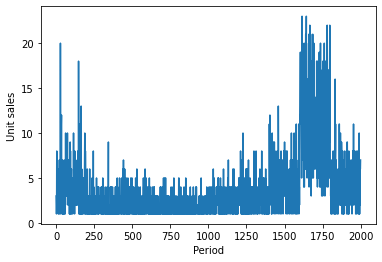

In [10]:
train_unit_sales = assortment_train_data['unit_sales']
plt.xlabel('Period')
plt.ylabel('Unit sales')
plt.plot(range(len(train_unit_sales)),train_unit_sales)
plt.show()


In [11]:
assortment_test_data

,date,item_nbr,unit_sales,onpromotion,weekday,DayFromWagePaid,DayToWagePaid,OilPrice,transactions,type
200,2014-11-27,103665.0,2.0,False,3,12,3,69.820000,1713.0,Work
201,2014-11-29,103665.0,4.0,False,5,14,1,66.953333,1304.0,Weekend
202,2014-11-30,103665.0,4.0,False,6,0,0,67.966667,540.0,Weekend
203,2014-12-01,103665.0,1.0,False,0,1,14,68.980000,1953.0,Holiday
204,2014-12-02,103665.0,1.0,False,1,2,13,66.990000,1819.0,Work
...,...,...,...,...,...,...,...,...,...,...
395,2015-06-10,153398.0,10.0,False,2,10,5,61.360000,1852.0,Work
396,2015-06-11,153398.0,3.0,False,3,11,4,60.740000,1789.0,Work
397,2015-06-12,153398.0,4.0,False,4,12,3,59.960000,1849.0,Work
398,2015-06-13,153398.0,7.0,False,5,13,2,59.816667,1282.0,Weekend


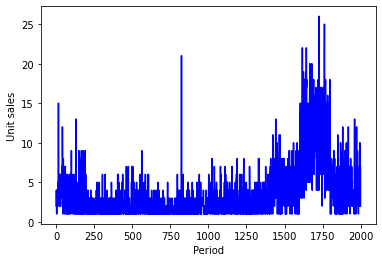

In [12]:
test_unit_sales = assortment_test_data['unit_sales']
plt.xlabel('Period')
plt.ylabel('Unit sales')
plt.plot(range(len(test_unit_sales)),test_unit_sales,'-b')
plt.show()


In [13]:
for i in range(1,11):
    assortment_train_data['assortment_'+str(i)] = 0
    assortment_train_data['assortment_'+str(i)][100*(i-1):100*i] = 1
    

C:\Users\s9421\AppData\Local\Temp/ipykernel_21304/1106701903.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assortment_train_data['assortment_'+str(i)][100*(i-1):100*i] = 1


In [14]:
for i in range(1,11):
    assortment_test_data['assortment_'+str(i)] = 0
    assortment_test_data['assortment_'+str(i)][50*(i-1):50*i] = 1

C:\Users\s9421\AppData\Local\Temp/ipykernel_21304/3810075648.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assortment_test_data['assortment_'+str(i)][50*(i-1):50*i] = 1


In [15]:
assortment_train_data['unit_sales_lag1'] = assortment_train_data['unit_sales'].shift(1)
assortment_test_data['unit_sales_lag1'] = assortment_test_data['unit_sales'].shift(1)

In [16]:
def indicator_func(x):
    if x == 0:
        return 1
    else:
        return 0

def onpromotion_func(x):
    if x :
        return 1
    else:
        return 0

def is_work_func(x):
    if x == 'Work':
        return 1
    else:
        return 0

def is_weekend_func(x):
    if x == 'Weekend':
        return 1
    else:
        return 0

def is_holiday_func(x):
    if x == 'Holiday':
        return 1
    else:
        return 0

def is_Sunday_func(x):
    if x == 0:
        return 1
    else:
        return 0

def is_Monday_func(x):
    if x == 1:
        return 1
    else:
        return 0

def is_Tuesday_func(x):
    if x == 2:
        return 1
    else:
        return 0

def is_Wednseday_func(x):
    if x == 3:
        return 1
    else:
        return 0

def is_Thursday_func(x):
    if x == 4:
        return 1
    else:
        return 0

def is_Friday_func(x):
    if x == 5:
        return 1
    else:
        return 0

def is_Saturday_func(x):
    if x == 6:
        return 1
    else:
        return 0

In [17]:
assortment_train_data['d1'] = assortment_train_data['unit_sales_lag1'].apply(indicator_func)
assortment_train_data['unit_sales_lag1']=np.maximum(1,assortment_train_data['unit_sales_lag1'])
assortment_train_data['ln_unit_sales_lag1']=np.log(assortment_train_data['unit_sales_lag1'])
assortment_train_data['OilPrice'] = (assortment_train_data['OilPrice']- assortment_train_data['OilPrice'].mean())/ assortment_train_data['OilPrice'].std()
assortment_train_data['transactions'] = (assortment_train_data['transactions']- assortment_train_data['transactions'].mean())/ assortment_train_data['transactions'].std()

In [18]:
assortment_test_data['d1'] = assortment_test_data['unit_sales_lag1'].apply(indicator_func)
assortment_test_data['unit_sales_lag1']=np.maximum(1,assortment_test_data['unit_sales_lag1'])
assortment_test_data['ln_unit_sales_lag1']=np.log(assortment_test_data['unit_sales_lag1'])
assortment_test_data['OilPrice'] = (assortment_test_data['OilPrice']- assortment_test_data['OilPrice'].mean())/ assortment_test_data['OilPrice'].std()
assortment_test_data['transactions'] = (assortment_test_data['transactions']- assortment_test_data['transactions'].mean())/ assortment_test_data['transactions'].std()

In [19]:
assortment_train_data['onpromotion'] = assortment_train_data['onpromotion'].apply(onpromotion_func)
assortment_train_data['work'] = assortment_train_data['type'].apply(is_work_func)
assortment_train_data['weekend'] = assortment_train_data['type'].apply(is_weekend_func)
assortment_train_data['holiday'] = assortment_train_data['type'].apply(is_holiday_func)

In [20]:
assortment_test_data['onpromotion'] = assortment_test_data['onpromotion'].apply(onpromotion_func)
assortment_test_data['work'] = assortment_test_data['type'].apply(is_work_func)
assortment_test_data['weekend'] = assortment_test_data['type'].apply(is_weekend_func)
assortment_test_data['holiday'] = assortment_test_data['type'].apply(is_holiday_func)

In [21]:
assortment_train_data['Sun'] = assortment_train_data['weekday'].apply(is_Sunday_func)
assortment_train_data['Mon'] = assortment_train_data['weekday'].apply(is_Monday_func)
assortment_train_data['Tue'] = assortment_train_data['weekday'].apply(is_Tuesday_func)
assortment_train_data['Wed'] = assortment_train_data['weekday'].apply(is_Wednseday_func)
assortment_train_data['Thu'] = assortment_train_data['weekday'].apply(is_Thursday_func)
assortment_train_data['Fri'] = assortment_train_data['weekday'].apply(is_Friday_func)
assortment_train_data['Sat'] = assortment_train_data['weekday'].apply(is_Saturday_func)

In [22]:
assortment_test_data['Sun'] = assortment_test_data['weekday'].apply(is_Sunday_func)
assortment_test_data['Mon'] = assortment_test_data['weekday'].apply(is_Monday_func)
assortment_test_data['Tue'] = assortment_test_data['weekday'].apply(is_Tuesday_func)
assortment_test_data['Wed'] = assortment_test_data['weekday'].apply(is_Wednseday_func)
assortment_test_data['Thu'] = assortment_test_data['weekday'].apply(is_Thursday_func)
assortment_test_data['Fri'] = assortment_test_data['weekday'].apply(is_Friday_func)
assortment_test_data['Sat'] = assortment_test_data['weekday'].apply(is_Saturday_func)

In [23]:
#assortment_train_data.to_csv('assortment_train_data.csv')
#assortment_test_data.to_csv('assortment_test_data.csv')

In [24]:
expr = 'unit_sales ~ ln_unit_sales_lag1 + assortment_1 + assortment_2 \
      + assortment_3 + assortment_4 + assortment_5 + assortment_6 + assortment_7 + assortment_8 + assortment_9 + assortment_10  '
y_train, x_train = dmatrices(expr, assortment_train_data, return_type='dataframe')

In [25]:
x_train

,Intercept,ln_unit_sales_lag1,assortment_1,assortment_2,assortment_3,assortment_4,assortment_5,assortment_6,assortment_7,assortment_8,assortment_9,assortment_10
1,1.0,1.098612,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.693147,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.693147,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,2.079442,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.0,1.791759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196,1.0,0.693147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197,1.0,1.098612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,1.0,1.791759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
print(y_train)

     unit_sales
1           2.0
2           1.0
3           2.0
4           8.0
5           3.0
..          ...
195         2.0
196         3.0
197         6.0
198         6.0
199         7.0

[1999 rows x 1 columns]


In [27]:
x_train.to_csv("x_train.csv")

# Training GP1 regression model and GP1 HMM

**Conduct GP1 regression**

In [28]:
gen_poisson_gp1 = sm.GeneralizedPoisson(y_train, x_train, p=1)
gen_poisson_gp1_results = gen_poisson_gp1.fit()

Optimization terminated successfully.
         Current function value: 2.175452
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26


**AIC**

In [29]:
print(gen_poisson_gp1_results.summary())

                    GeneralizedPoisson Regression Results                     
Dep. Variable:             unit_sales   No. Observations:                 1999
Model:             GeneralizedPoisson   Df Residuals:                     1987
Method:                           MLE   Df Model:                           11
Date:                Sat, 16 Jul 2022   Pseudo R-squ.:                 0.07070
Time:                        11:08:27   Log-Likelihood:                -4348.7
converged:                       True   LL-Null:                       -4679.6
Covariance Type:            nonrobust   LLR p-value:                8.853e-135
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.0569      0.036     29.097      0.000       0.986       1.128
ln_unit_sales_lag1     0.3840      0.021     18.649      0.000       0.344       0.424
assortment_1        

In [30]:
gen_poisson_gp1_results.aic

8723.457960899426

In [31]:
gp1_regression_prediction = np.exp(x_train.dot(gen_poisson_gp1_results.params[:-1]))

In [32]:
(y_train)

,unit_sales
1,2.0
2,1.0
3,2.0
4,8.0
5,3.0
...,...
195,2.0
196,3.0
197,6.0
198,6.0


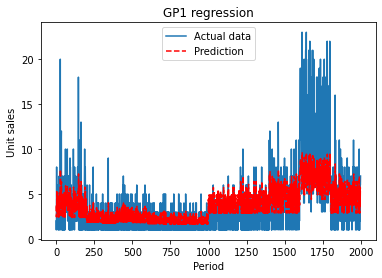

In [33]:
#Plot the number of unit sales in each period
y = y_train['unit_sales']

plt.xlabel('Period')
plt.ylabel('Unit sales')
plt.title("GP1 regression")
plt.plot(range(len(y)),y,label = 'Actual data')
plt.plot(range(len(gp1_regression_prediction)),gp1_regression_prediction,'--r',label = 'Prediction')
plt.legend()
plt.show()

**MAE**

In [34]:
np.abs(gp1_regression_prediction - y).mean()


2.0285187032691976

**Conduct GP1 HMM with covariate training**

In [35]:
cor = 'unit_sales ~ DayToWagePaid + Sun + Mon + Tue + Wed + Thu + Fri + Sat '
y, covariate = dmatrices(cor, assortment_train_data, return_type='dataframe')
#del covariate['DayToWagePaid']

In [36]:
length = np.array([199, 200, 200, 200, 200, 200, 200, 200, 200, 200])

In [37]:
k_regimes = 2
extra_params_names = []

for regime_num in range(1, k_regimes):
    for param_name in x_train.columns:
        extra_params_names.append(param_name+'_R'+str(regime_num))

for k in range(k_regimes-1):
    extra_params_names.append('Initial state_'+str(k))

for regime_num in range(k_regimes):
#    extra_params_names.append("Intercept_"+str(regime_num))
    for param_name in covariate.columns:
        extra_params_names.append(param_name+"_"+str(regime_num))
    

#for i in range(k_regimes):
#    for j in range(k_regimes-2):
#        extra_params_names.append('q_'+str(i)+str(j))

for k in range(k_regimes):
    extra_params_names.append('alpha '+ str(k))

In [38]:
gp1_hmm = GP1HMM(endog=y_train, exog=x_train, covariate=covariate,
                        k_regimes=k_regimes,length=length,
                        extra_params_names=extra_params_names)

params = gp1_hmm.start_params
params[:-2] = params[:-2] /1000


In [39]:
gp1_hmm.start_params.shape[0]
const1 = np.zeros([gp1_hmm.start_params.shape[0]])
const1[-2:] = 1
const1[-1] = 0

const2 = np.zeros([gp1_hmm.start_params.shape[0]])
const2[-1] = 1


In [40]:
constraint1 = opt.LinearConstraint(list(const1), 0, 1)
constraint2 = opt.LinearConstraint(list(const2), 0, 1)

In [41]:
res=opt.minimize(gp1_hmm.nloglikeopt,params, method='Nelder-Mead',constraints = (constraint1, constraint2))

#gp1_hmm_results = gp1_hmm.fit(method='bfgs', maxiter=400)

C:\Users\s9421\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\_minimize.py:521: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


ITER=1 ll=9800.243419609174 MAE=2.7597376268850273
ITER=2 ll=9800.117932300163 MAE=2.7597367742092196
ITER=3 ll=9800.062581639175 MAE=2.7597079396911757
ITER=4 ll=9800.236476974826 MAE=2.759736045984669
ITER=5 ll=9800.236752019504 MAE=2.759736071084413
ITER=6 ll=9800.240201204582 MAE=2.7597368244104032
ITER=7 ll=9800.240950944992 MAE=2.759737476613112
ITER=8 ll=9800.240026284719 MAE=2.759736724063648
ITER=9 ll=9800.24055111461 MAE=2.75973707519766
ITER=10 ll=9800.241250850198 MAE=2.7597375266348805
ITER=11 ll=9800.241475699182 MAE=2.7597378275802957
ITER=12 ll=9800.24157566961 MAE=2.7597378776361063
ITER=13 ll=9800.241650656688 MAE=2.7597377272434995
ITER=14 ll=9800.117932726745 MAE=2.7597376268850273
ITER=15 ll=9800.062582094759 MAE=2.7597376268850273
ITER=16 ll=9800.236476987287 MAE=2.7597376268850273
ITER=17 ll=9800.236752019504 MAE=2.7597376268850273
ITER=18 ll=9800.240201204559 MAE=2.7597376268850273
ITER=19 ll=9800.240950944992 MAE=2.7597376268850273
ITER=20 ll=9800.240026297544 

In [148]:
for i in range(1): #5
    res=opt.minimize(gp1_hmm.nloglikeopt,res.x, method='Nelder-Mead')

ITER=45001 ll=4130.616402875458 MAE=2.1013509245972393
ITER=45002 ll=4136.286544308676 MAE=2.1492815240066587
ITER=45003 ll=4132.065701734435 MAE=2.1122873085888596
ITER=45004 ll=4130.612880989038 MAE=2.101085783850068
ITER=45005 ll=4130.604004379865 MAE=2.100920773059338
ITER=45006 ll=4130.626364196194 MAE=2.1006672460740408
ITER=45007 ll=4130.698999744999 MAE=2.100729891354563
ITER=45008 ll=4130.641236273363 MAE=2.1008262755806038
ITER=45009 ll=4130.643258033774 MAE=2.1007185224475977
ITER=45010 ll=4130.711418276609 MAE=2.101242386249301
ITER=45011 ll=4130.660400313573 MAE=2.1008194388603747
ITER=45012 ll=4130.63643621605 MAE=2.10110105756033
ITER=45013 ll=4130.681976689754 MAE=2.1007758970081603
ITER=45014 ll=4132.362328496805 MAE=2.089562887083737
ITER=45015 ll=4130.834684163623 MAE=2.0960356090104555
ITER=45016 ll=4130.613971958488 MAE=2.101396393249911
ITER=45017 ll=4130.613544877001 MAE=2.1013234069834352
ITER=45018 ll=4130.624975364482 MAE=2.101465121068982
ITER=45019 ll=4130.6

In [96]:
print(res)

 final_simplex: (array([[ 1.50309237,  0.3694572 , -0.12616743, ...,  1.64916959,
         0.17816254, -0.29408209],
       [ 1.50312982,  0.36949725, -0.12623874, ...,  1.64369615,
         0.17786369, -0.29429634],
       [ 1.50290873,  0.36957126, -0.12655728, ...,  1.64313831,
         0.17809992, -0.29407377],
       ...,
       [ 1.50310372,  0.36966352, -0.12639493, ...,  1.6592693 ,
         0.17796058, -0.29330075],
       [ 1.50314727,  0.36962329, -0.12522496, ...,  1.65089566,
         0.17810876, -0.29400596],
       [ 1.5025038 ,  0.36971002, -0.12625013, ...,  1.65473122,
         0.17826142, -0.29428645]]), array([4132.55657284, 4132.55660161, 4132.55664851, 4132.55677991,
       4132.55678153, 4132.55680325, 4132.55694854, 4132.55704828,
       4132.55718506, 4132.55725523, 4132.55725995, 4132.55733694,
       4132.55734566, 4132.5573484 , 4132.55738657, 4132.5574218 ,
       4132.55749587, 4132.55752207, 4132.55754309, 4132.55757161,
       4132.55763042, 4132.5576645

In [97]:
res.x

array([ 1.50309237e+00,  3.69457202e-01, -1.26167435e-01, -2.14544983e-01,
       -7.04965366e-01, -8.95514093e-01, -6.03505762e-01, -7.72647006e-01,
       -8.68881460e-01, -8.57282543e-01, -8.56650288e-01, -9.29140712e-01,
        7.74679124e-01,  1.58313450e-01, -6.39445898e-02,  5.71906720e-03,
       -2.17798691e-01, -2.32755343e-01, -2.76720123e-01, -2.32645599e-01,
       -3.51375887e-01, -4.63025251e-01, -4.94971396e-01, -4.25790497e-01,
       -2.83593790e-02, -7.17743737e-01, -6.85532150e-03,  3.50326411e-02,
       -4.89480111e-01, -3.24664585e-01,  2.41531990e-01, -5.16142390e-04,
       -2.43377524e+00,  1.30166130e+00, -3.55705211e-01,  2.13952917e-02,
       -4.10097816e-01, -2.31183560e-01, -4.23886410e-01, -3.21164304e-03,
        1.06266378e+01, -3.46705788e-01,  1.64916959e+00,  1.78162539e-01,
       -2.94082088e-01])

In [138]:
gp1_hmm.sort()
'''(gp1_hmm_results.params = gp1_hmm.beta_matrix.flatten()
gp1_hmm_results.params = np.append(gp1_hmm_results.params, gp1_hmm.initial_state_matrix.flatten())
gp1_hmm_results.params = np.append(gp1_hmm_results.params, gp1_hmm.covariate_beta_matrix.flatten())
if k_regimes>2:
    gp1_hmm_results.params = np.append(gp1_hmm_results.params, gp1_hmm.q_matrix.flatten()))'''
    
print('Mean of transition matrix:')
print(np.mean(gp1_hmm.gamma_matrix,axis = 0))

Mean of transition matrix:
[[0.51356752 0.48643248]
 [0.75430702 0.24569298]]


**Emission**

In [99]:
for k in range(k_regimes):
    for i  in range(gp1_hmm.beta_matrix.shape[1]):
        print(x_train.columns[i],str(k + 1)+':',np.round(gp1_hmm.beta_matrix[k][i], decimals=2),end='. ')
    print('')

Intercept 1: 0.78. ln_unit_sales_lag1 1: 0.16. assortment_1 1: -0.06. assortment_2 1: 0.01. assortment_3 1: -0.22. assortment_4 1: -0.23. assortment_5 1: -0.28. assortment_6 1: -0.23. assortment_7 1: -0.35. assortment_8 1: -0.46. assortment_9 1: -0.49. assortment_10 1: -0.43. 
Intercept 2: 1.5. ln_unit_sales_lag1 2: 0.37. assortment_1 2: -0.13. assortment_2 2: -0.21. assortment_3 2: -0.7. assortment_4 2: -0.9. assortment_5 2: -0.6. assortment_6 2: -0.77. assortment_7 2: -0.87. assortment_8 2: -0.86. assortment_9 2: -0.85. assortment_10 2: -0.93. 


**Transition Matrix**

In [100]:
for k in range(k_regimes):
    for i  in range(gp1_hmm.covariate_beta_matrix.shape[1]):
        print(covariate.columns[i],str(k + 1)+':',np.round(gp1_hmm.covariate_beta_matrix[k][i], decimals=2),end='. ')
    print('')

Intercept 1: -0.35. DayToWagePaid 1: 0.02. Sun 1: -0.41. Mon 1: -0.23. Tue 1: -0.42. Wed 1: -0.0. Thu 1: 10.66. Fri 1: -0.35. Sat 1: 1.66. 
Intercept 2: -0.72. DayToWagePaid 2: -0.01. Sun 2: 0.04. Mon 2: -0.49. Tue 2: -0.32. Wed 2: 0.24. Thu 2: -0.0. Fri 2: -2.46. Sat 2: 1.31. 


In [101]:
gp1_hmm.decode()

In [134]:
state_specific_mu = np.zeros([y_train.shape[0]])
for t in range(y_train.shape[0]):
    if (gp1_hmm.decode_matrix[t] == 1):
        state_specific_mu[t] = gp1_hmm.mu_matrix[t][0]
    elif(gp1_hmm.decode_matrix[t] == 2):
        state_specific_mu[t] = gp1_hmm.mu_matrix[t][1]
    else:
        state_specific_mu[t] = gp1_hmm.mu_matrix[t][2]

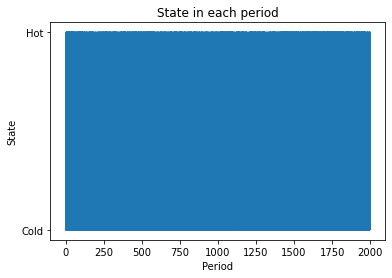

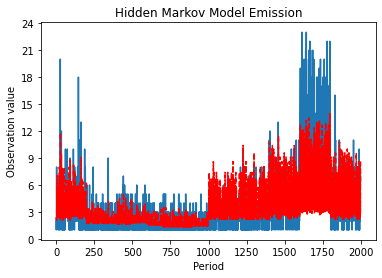

In [149]:
from matplotlib.ticker import MaxNLocator

#Plot the state each month
plt.xlabel('Period')
plt.ylabel('State')
plt.title("State in each period")
plt.yticks([1,2],['Cold','Hot'])
plt.plot(range(y_train.shape[0]),gp1_hmm.decode_matrix)
plt.show()

#Plot the number of strikes starting each month
plt.xlabel('Period')
plt.ylabel('Observation value')
plt.title("Hidden Markov Model Emission")
plt.plot(range(y_train.shape[0]),assortment_train_data['unit_sales'][1:])
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

#Plot the mu_2 each month
plt.plot(range(y_train.shape[0]),gp1_hmm.state_specific_mu,'--r')

plt.show()

**MAE**

In [136]:
np.abs(state_specific_mu-assortment_train_data['unit_sales'][1:]).mean()

2.1212000523200376

**AIC**

In [105]:
int((-(gp1_hmm.ll_history[-1])*2+gp1_hmm.start_params.shape[0]*2))

8355

In [141]:
gp1_hmm.alpha

array([[ 0.17964273],
       [-0.28312584]])

# Testing data performance

**Test data evaluation**

In [107]:
y_train, x_train = dmatrices(expr, assortment_train_data, return_type='dataframe')
y_test, x_test = dmatrices(expr, assortment_test_data, return_type='dataframe')

In [108]:
length_test = [199, 200, 200, 200, 200, 200, 200, 200, 200, 200]

### GP1 regression models in testing data performance

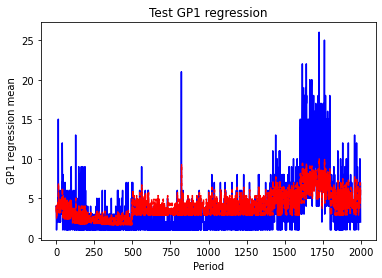

In [109]:
test_gp1_regression_prediction = np.exp(x_test.dot(gen_poisson_gp1_results.params[:-1]))
y_test_set = y_test['unit_sales']
#Plot the number of unit sales in each period
plt.xlabel('Period')
plt.ylabel('Unit sales')
plt.plot(range(len(y_test_set)),y_test_set,'-b')

plt.xlabel('Period')
plt.ylabel(' GP1 regression mean')
plt.title("Test GP1 regression")
plt.plot(range(len(test_gp1_regression_prediction)),test_gp1_regression_prediction,'--r')

plt.show()

**MAE**

In [110]:
np.abs(test_gp1_regression_prediction - assortment_test_data['unit_sales'][1:]).mean()


2.1663287802981674

**LL**

In [111]:
gen_poisson_gp1_test = sm.GeneralizedPoisson(y_test, x_test, p=1)
gen_poisson_gp1_test.loglikeobs(gen_poisson_gp1_results.params).sum()


-4413.260689817046

**AIC**

In [112]:
gen_poisson_gp1_test.loglikeobs(gen_poisson_gp1_results.params).sum()*(-2) + gen_poisson_gp1_results.params.shape[0]*2

8852.521379634092

### GP1 HMM in testing data performance

In [154]:
y, covariate_test = dmatrices(cor, assortment_test_data, return_type='dataframe')
#del covariate['DayToWagePaid']

In [155]:
gp1_hmm_test = GP1HMM(endog=y_test, exog=x_test, covariate=covariate_test,
                        k_regimes=k_regimes,length = length_test,
                        extra_params_names=extra_params_names)


**LL and MAE**

In [156]:
params = gp1_hmm.params_history[45389]
gp1_hmm_test.nloglikeopt(params)

ITER=1 ll=4250.9179070578975 MAE=2.259350828782646


4250.9179070578975

In [157]:
gp1_hmm_test.nloglikeopt(params)*2 + params.shape[0]*2

ITER=2 ll=4250.9179070578975 MAE=2.259350828782646


8591.835814115795

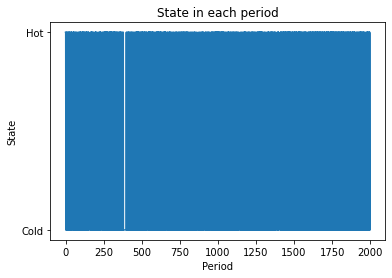

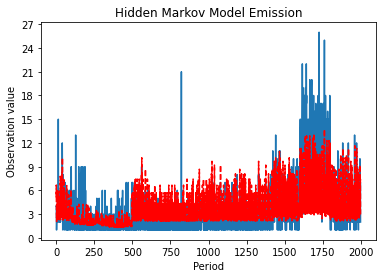

In [158]:
from matplotlib.ticker import MaxNLocator

#Plot the state each month
plt.xlabel('Period')
plt.ylabel('State')
plt.title("State in each period")
plt.yticks([1,2],['Cold','Hot'])
plt.plot(range(y_test.shape[0]),gp1_hmm_test.decode_matrix)
plt.show()

#Plot the number of strikes starting each month
plt.xlabel('Period')
plt.ylabel('Observation value')
plt.title("Hidden Markov Model Emission")
plt.plot(range(y_test.shape[0]),assortment_test_data['unit_sales'][1:])
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

#Plot the mu_2 each month
plt.plot(range(y_test.shape[0]),gp1_hmm_test.state_specific_mu,'--r')

plt.show()

### **Training set performance (Iter = 45389)**

In [159]:
gp1_hmm_train = GP1HMM(endog=y_train, exog=x_train, covariate=covariate,
                        k_regimes=k_regimes,length=length,
                        extra_params_names=extra_params_names)


gp1_hmm_train.nloglikeopt(params)

ITER=1 ll=4130.1105151296715 MAE=2.0896671930558153


4130.1105151296715

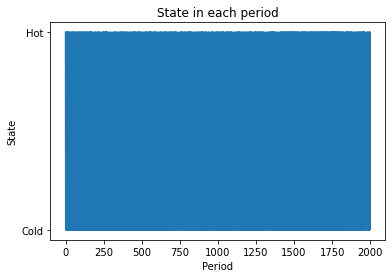

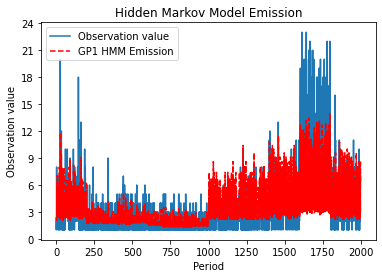

In [172]:
from matplotlib.ticker import MaxNLocator

#Plot the state each month
plt.xlabel('Period')
plt.ylabel('State')
plt.title("State in each period")
plt.yticks([1,2],['Cold','Hot'])
plt.plot(range(y_train.shape[0]),gp1_hmm_train.decode_matrix)
plt.show()

#Plot the number of strikes starting each month
plt.xlabel('Period')
plt.ylabel('Observation value')
plt.title("Hidden Markov Model Emission")
plt.plot(range(y_train.shape[0]),assortment_train_data['unit_sales'][1:], label = 'Observation value')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

#Plot the mu_2 each month
plt.plot(range(y_train.shape[0]),gp1_hmm.state_specific_mu,'--r',label = 'GP1 HMM Emission')
plt.legend(loc = 2)
plt.show()

**AIC**

In [161]:
params.shape[0]*2+gp1_hmm_train.nloglikeopt(params)*2

ITER=2 ll=4130.1105151296715 MAE=2.0896671930558153


8350.221030259343

**Emission**

In [93]:
for k in range(k_regimes):
    for i  in range(gp1_hmm_train.beta_matrix.shape[1]):
        print(x_train.columns[i],str(k + 1)+':',np.round(gp1_hmm_train.beta_matrix[k][i], decimals=2),end='. ')
    print('')

Intercept 1: 0.68. ln_unit_sales_lag1 1: 0.21. assortment_1 1: -0.03. assortment_2 1: 0.02. assortment_3 1: -0.13. assortment_4 1: -0.41. assortment_5 1: -0.26. assortment_6 1: -0.06. assortment_7 1: -0.32. assortment_8 1: -0.3. assortment_9 1: -0.42. assortment_10 1: -0.12. 
Intercept 2: 1.42. ln_unit_sales_lag1 2: 0.41. assortment_1 2: -0.15. assortment_2 2: -0.13. assortment_3 2: -0.61. assortment_4 2: -0.39. assortment_5 2: -0.44. assortment_6 2: -0.87. assortment_7 2: -0.79. assortment_8 2: -0.85. assortment_9 2: -0.85. assortment_10 2: -1.03. 


**Transition Matrix**

In [94]:
for k in range(k_regimes):
    for i  in range(gp1_hmm_train.covariate_beta_matrix.shape[1]):
        print(covariate.columns[i],str(k + 1)+':',np.round(gp1_hmm_train.covariate_beta_matrix[k][i], decimals=2),end='. ')
    print('')

Intercept 1: -0.46. DayToWagePaid 1: 0.03. Sun 1: -0.6. Mon 1: -0.47. Tue 1: -0.27. Wed 1: -0.0. Thu 1: 9.15. Fri 1: -0.22. Sat 1: -0.32. 
Intercept 2: -0.44. DayToWagePaid 2: -0.01. Sun 2: 0.01. Mon 2: -0.81. Tue 2: -1.08. Wed 2: 0.35. Thu 2: 0.0. Fri 2: -1.03. Sat 2: -1.0. 


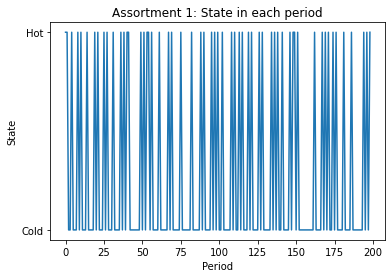

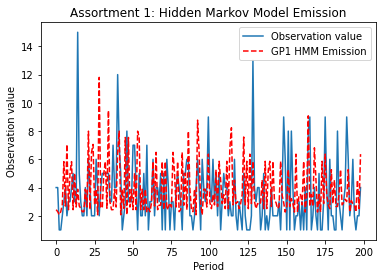

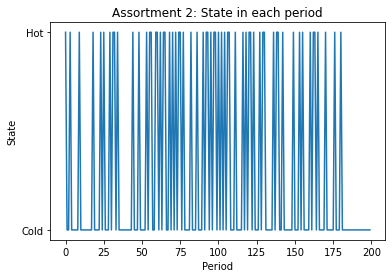

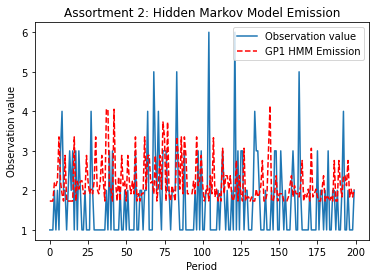

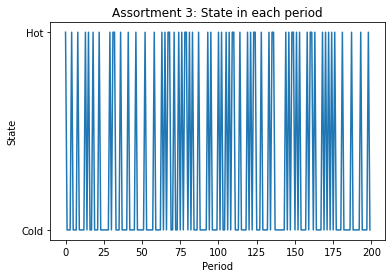

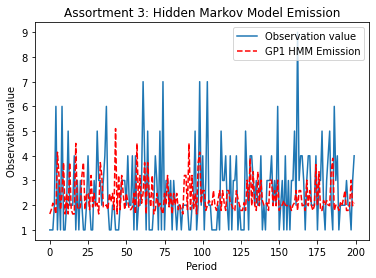

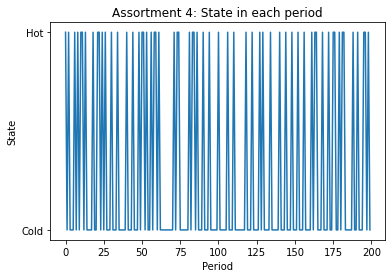

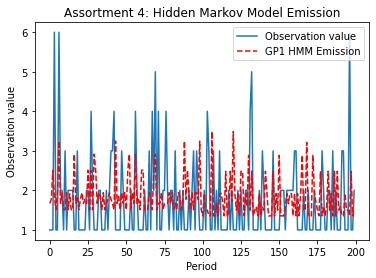

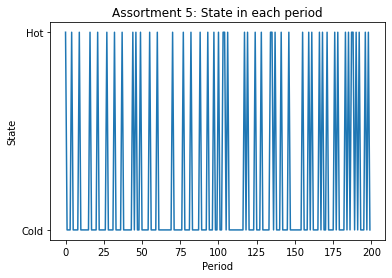

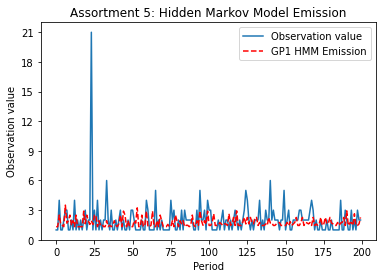

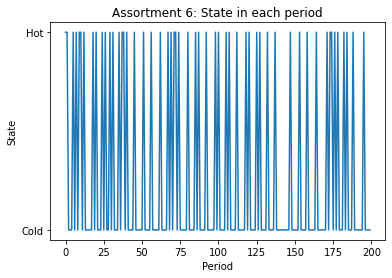

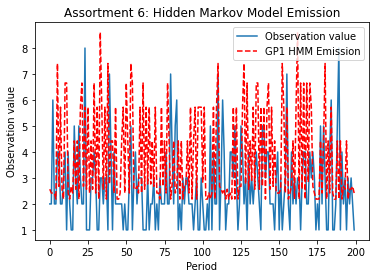

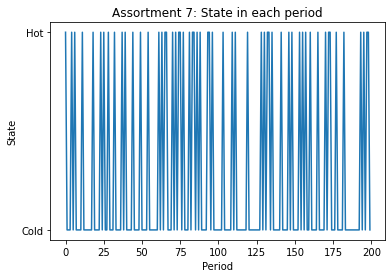

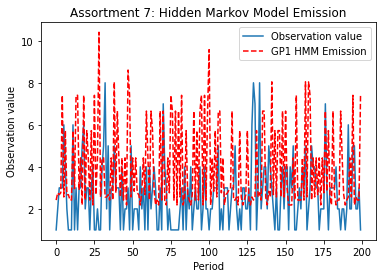

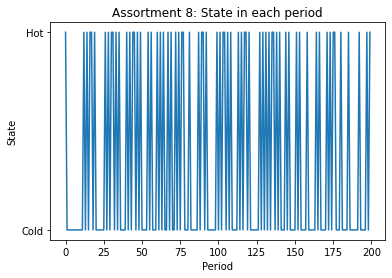

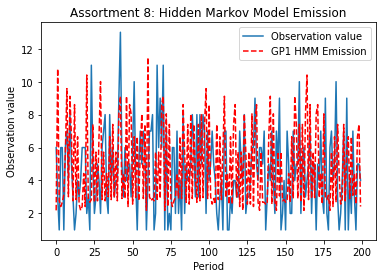

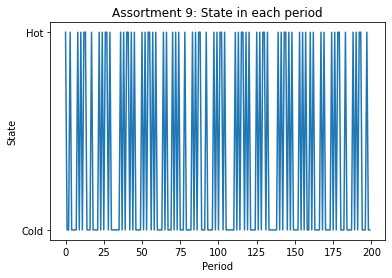

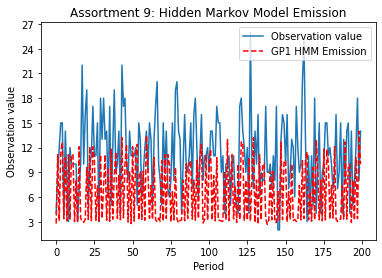

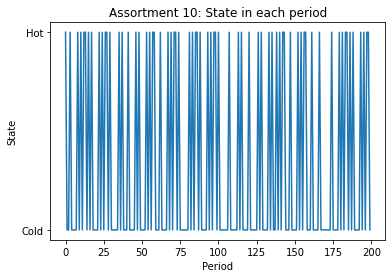

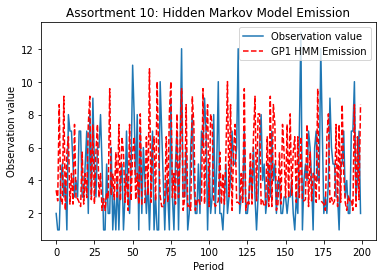

In [181]:
from matplotlib.ticker import MaxNLocator
index = 0
for  i in range(10):
    #Plot the state each day
    plt.xlabel('Period')
    plt.ylabel('State')
    plt.title("Assortment "+str(i+1)+": State in each period")
    plt.yticks([1,2],['Cold','Hot'])
    plt.plot(range(length[i]),gp1_hmm_test.decode_matrix[index:index+length[i]])
    plt.show()

    #Plot the number of strikes starting each month
    plt.xlabel('Period')
    plt.ylabel('Observation value')
    plt.title("Assortment "+str(i+1)+": Hidden Markov Model Emission")
    plt.plot(range(length[i]),y_test[index:index+length[i]], label = 'Observation value')
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

    #Plot the mu_2 each month
    plt.plot(range(length[i]),gp1_hmm.state_specific_mu[index:index+length[i]],'--r',label = 'GP1 HMM Emission')
    plt.legend(loc = 1)
    plt.show()
    index += length[i]